In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

2022-12-08 17:46:46.311865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 17:46:46.400961: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-08 17:46:46.421717: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-08 17:46:46.826041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config_directory = 'edge_detection_with_prior'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
Model = model.Model(config_path)
DataProcessing = dataset.DataProcessing(input_shape_img=Model.cfg["INPUT_SHAPE_IMG"],
                                        input_shape_mask=Model.cfg["INPUT_SHAPE_MASK"],
                                        output_shape=Model.cfg["OUTPUT_SHAPE"],
                                        config_path=config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.path_definitions()

2022-12-08 17:46:47.955878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:46:47.961294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:46:47.961410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:46:47.961907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

# Load Dataset, Preprocess Images and Dataset

The TRAIN DS contains 500 images.
The TEST DS contains 103 images.
The IMG_ONLY DS contains 20 images.


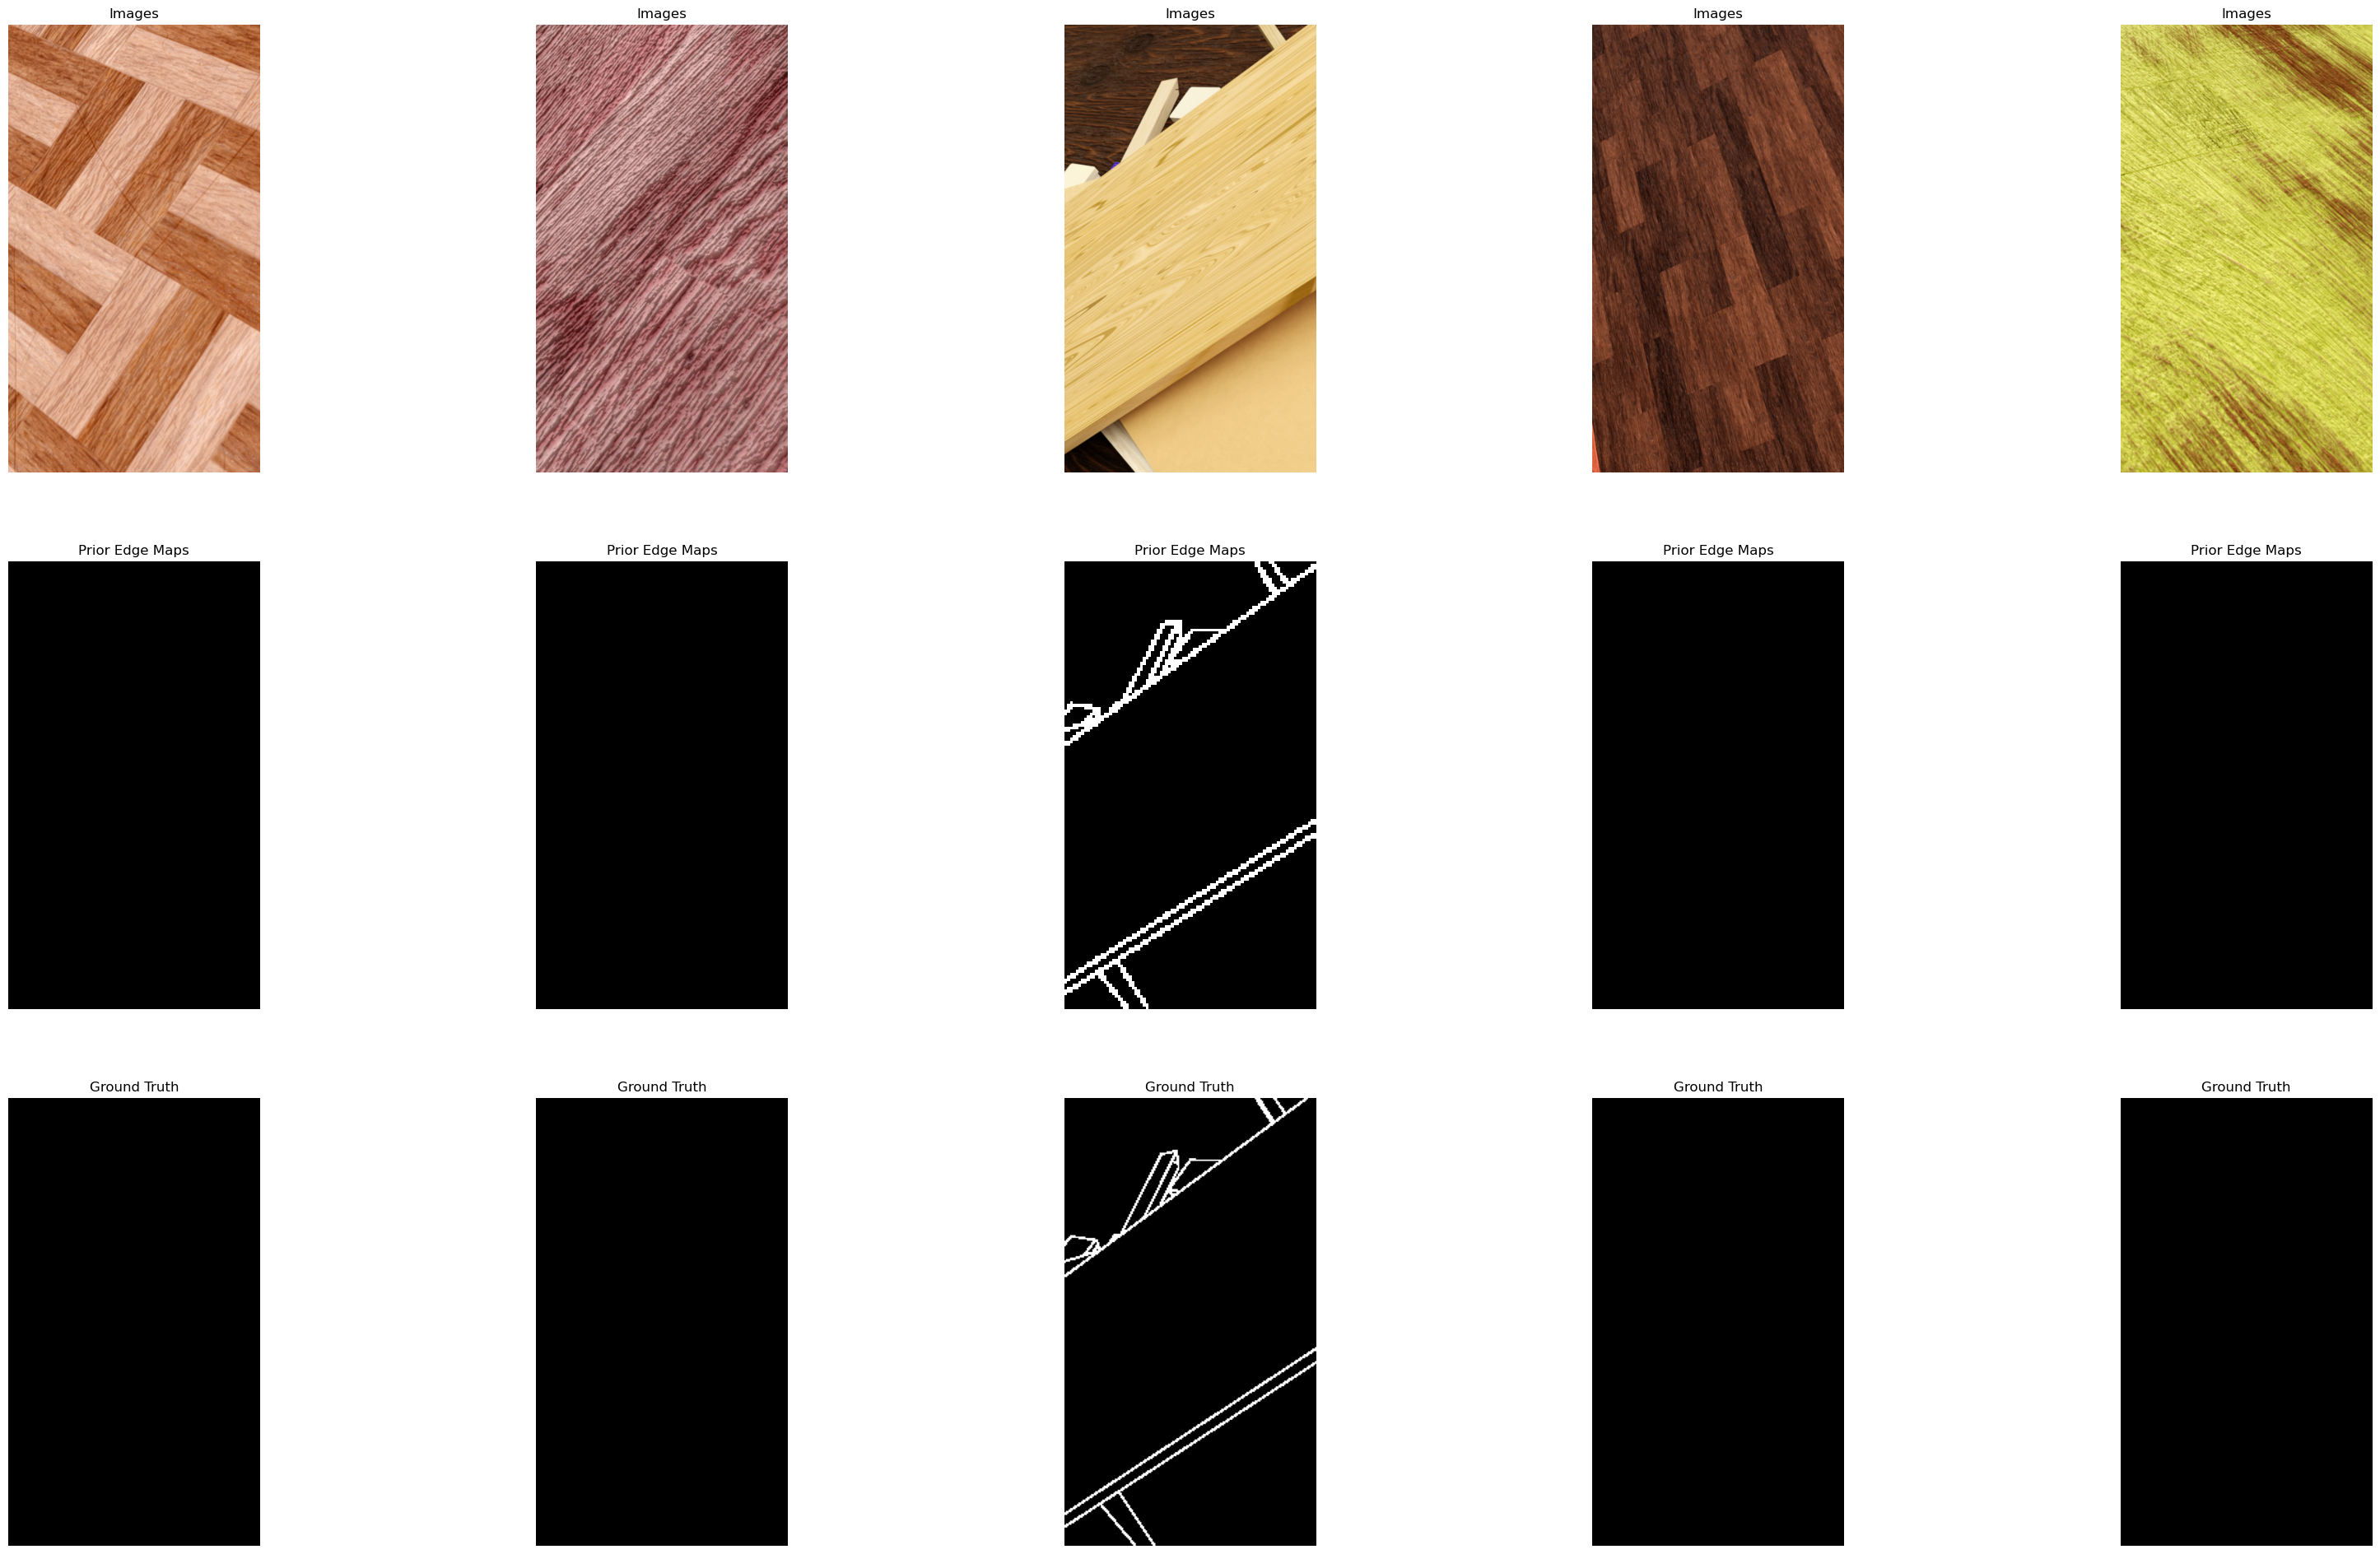

In [3]:
if Model.train_model:
    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

img_only_ds, img_count_img_only_ds = DataProcessing.load_dataset(DataProcessing.key.img_only)

if Model.train_model:
    for inp, out in train_ds.take(1):
        edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
                                        prior = inp['in_edge'],
                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                        num_classes=DataProcessing.num_classes['edge'])

# Define, Compile and Train Model

In [4]:
if Model.train_model:
    model = Model.get_neural_network_model(DataProcessing.num_classes['edge'])
    # model.summary()

    lr = Model.get_lr(img_count_train, DataProcessing.cfg['TRAIN']['BATCH_SIZE'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=Model.get_loss_function(),
                  metrics=Model.get_metrics(DataProcessing.num_classes['edge']))

    history = model.fit(train_ds, epochs=Model.cfg["EPOCHS"], validation_data=train_ds,
                        callbacks=Model.get_callbacks(), verbose=1)

model = Model.get_best_model_from_checkpoints()

(640, 360, 3)
Epoch 1/40


2022-12-08 17:46:56.459913: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-08 17:46:56.900404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


100/100 [==============================] - 15s 108ms/step - loss: 717.6922 - out_edge_loss: 717.6922 - accuracy: 0.9342 - accuracy_1: 0.9342 - f1: 0.4316 - precision: 0.4063 - recall: 0.4671 - f1_1: 0.4316 - precision_1: 0.4063 - recall_1: 0.4671 - val_loss: 1222.4554 - val_out_edge_loss: 1222.4554 - val_accuracy: 0.8953 - val_accuracy_1: 0.8953 - val_f1: 0.4711 - val_precision: 0.3110 - val_recall: 0.9713 - val_f1_1: 0.4711 - val_precision_1: 0.3110 - val_recall_1: 0.9713
Epoch 2/40
100/100 [==============================] - 10s 101ms/step - loss: 406.7831 - out_edge_loss: 406.7831 - accuracy: 0.9755 - accuracy_1: 0.9755 - f1: 0.7694 - precision: 0.7291 - recall: 0.8148 - f1_1: 0.7694 - precision_1: 0.7291 - recall_1: 0.8148 - val_loss: 2778.3491 - val_out_edge_loss: 2778.3491 - val_accuracy: 0.7667 - val_accuracy_1: 0.7667 - val_f1: 0.2897 - val_precision: 0.1696 - val_recall: 0.9904 - val_f1_1: 0.2897 - val_precision_1: 0.1696 - val_recall_1: 0.9904
Epoch 3/40
100/100 [=============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=249.48-epoch=10.00-f1=0.8645/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=249.48-epoch=10.00-f1=0.8645/assets


100/100 [==============================] - 18s 177ms/step - loss: 257.7598 - out_edge_loss: 257.7598 - accuracy: 0.9850 - accuracy_1: 0.9850 - f1: 0.8482 - precision: 0.8107 - recall: 0.8895 - f1_1: 0.8482 - precision_1: 0.8107 - recall_1: 0.8895 - val_loss: 249.4807 - val_out_edge_loss: 249.4807 - val_accuracy: 0.9865 - val_accuracy_1: 0.9865 - val_f1: 0.8645 - val_precision: 0.8333 - val_recall: 0.8982 - val_f1_1: 0.8645 - val_precision_1: 0.8333 - val_recall_1: 0.8982
Epoch 11/40
100/100 [==============================] - 10s 100ms/step - loss: 249.2766 - out_edge_loss: 249.2766 - accuracy: 0.9861 - accuracy_1: 0.9861 - f1: 0.8608 - precision: 0.8270 - recall: 0.8977 - f1_1: 0.8608 - precision_1: 0.8270 - recall_1: 0.8977 - val_loss: 317.9488 - val_out_edge_loss: 317.9488 - val_accuracy: 0.9819 - val_accuracy_1: 0.9819 - val_f1: 0.8236 - val_precision: 0.7742 - val_recall: 0.8797 - val_f1_1: 0.8236 - val_precision_1: 0.7742 - val_recall_1: 0.8797
Epoch 12/40
100/100 [===============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=224.78-epoch=20.00-f1=0.8675/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=224.78-epoch=20.00-f1=0.8675/assets


100/100 [==============================] - 17s 173ms/step - loss: 225.2917 - out_edge_loss: 225.2917 - accuracy: 0.9869 - accuracy_1: 0.9869 - f1: 0.8716 - precision: 0.8369 - recall: 0.9093 - f1_1: 0.8716 - precision_1: 0.8369 - recall_1: 0.9093 - val_loss: 224.7774 - val_out_edge_loss: 224.7774 - val_accuracy: 0.9864 - val_accuracy_1: 0.9864 - val_f1: 0.8675 - val_precision: 0.8136 - val_recall: 0.9292 - val_f1_1: 0.8675 - val_precision_1: 0.8136 - val_recall_1: 0.9292
Epoch 21/40
100/100 [==============================] - 10s 100ms/step - loss: 220.9836 - out_edge_loss: 220.9836 - accuracy: 0.9868 - accuracy_1: 0.9868 - f1: 0.8757 - precision: 0.8400 - recall: 0.9146 - f1_1: 0.8757 - precision_1: 0.8400 - recall_1: 0.9146 - val_loss: 332.7195 - val_out_edge_loss: 332.7195 - val_accuracy: 0.9809 - val_accuracy_1: 0.9809 - val_f1: 0.8170 - val_precision: 0.7577 - val_recall: 0.8864 - val_f1_1: 0.8170 - val_precision_1: 0.7577 - val_recall_1: 0.8864
Epoch 22/40
100/100 [===============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=209.54-epoch=30.00-f1=0.8873/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=209.54-epoch=30.00-f1=0.8873/assets


100/100 [==============================] - 18s 178ms/step - loss: 209.0065 - out_edge_loss: 209.0065 - accuracy: 0.9877 - accuracy_1: 0.9877 - f1: 0.8745 - precision: 0.8350 - recall: 0.9180 - f1_1: 0.8745 - precision_1: 0.8350 - recall_1: 0.9180 - val_loss: 209.5428 - val_out_edge_loss: 209.5428 - val_accuracy: 0.9890 - val_accuracy_1: 0.9890 - val_f1: 0.8873 - val_precision: 0.8764 - val_recall: 0.8986 - val_f1_1: 0.8873 - val_precision_1: 0.8764 - val_recall_1: 0.8986
Epoch 31/40
100/100 [==============================] - 10s 100ms/step - loss: 208.7825 - out_edge_loss: 208.7825 - accuracy: 0.9883 - accuracy_1: 0.9883 - f1: 0.8787 - precision: 0.8434 - recall: 0.9171 - f1_1: 0.8787 - precision_1: 0.8434 - recall_1: 0.9171 - val_loss: 213.2242 - val_out_edge_loss: 213.2242 - val_accuracy: 0.9878 - val_accuracy_1: 0.9878 - val_f1: 0.8779 - val_precision: 0.8423 - val_recall: 0.9166 - val_f1_1: 0.8779 - val_precision_1: 0.8423 - val_recall_1: 0.9166
Epoch 32/40
100/100 [===============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=194.09-epoch=40.00-f1=0.8926/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=194.09-epoch=40.00-f1=0.8926/assets


100/100 [==============================] - 17s 173ms/step - loss: 196.2300 - out_edge_loss: 196.2300 - accuracy: 0.9887 - accuracy_1: 0.9887 - f1: 0.8849 - precision: 0.8530 - recall: 0.9192 - f1_1: 0.8849 - precision_1: 0.8530 - recall_1: 0.9192 - val_loss: 194.0917 - val_out_edge_loss: 194.0917 - val_accuracy: 0.9895 - val_accuracy_1: 0.9895 - val_f1: 0.8926 - val_precision: 0.8756 - val_recall: 0.9104 - val_f1_1: 0.8926 - val_precision_1: 0.8756 - val_recall_1: 0.9104
/home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=194.09-epoch=40.00-f1=0.8926


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/TFLITE/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/TFLITE/assets


In [5]:
model.summary()


tf.keras.utils.plot_model(
    model,
    to_file=Model.Data.paths['FIGURES']+"/model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_edge (InputLayer)           [(None, 160, 90, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 edge_map_processing_1_conv (Co  (None, 160, 90, 5)  50          ['in_edge[0][0]']                
 nv2D)                                                                                            
                                                                                                  
 edge_map_processing_1_bn (Batc  (None, 160, 90, 5)  20          ['edge_map_processing_1_conv[0][0
 hNormalization)                                                 ]']                          

 hNormalization)                                                 ]']                              
                                                                                                  
 pyramid_module_image_1_2_relu   (None, 160, 90, 5)  0           ['pyramid_module_image_1_2_bn[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 pyramid_module_edge_1_relu (Re  (None, 160, 90, 5)  0           ['pyramid_module_edge_1_bn[0][0]'
 LU)                                                             ]                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 160, 90, 10)  0           ['pyramid_module_image_1_2_relu[0
                                                                 ][0]',                           
          

 atchNormalization)                                              ble_conv[0][0]']                 
                                                                                                  
 pyramid_module_pyramid_out_bn   (None, 80, 45, 5)   20          ['pyramid_module_pyramid_out_conv
 (BatchNormalization)                                            [0][0]']                         
                                                                                                  
 pyramid_module_image_2_1_relu   (None, 160, 90, 5)  0           ['pyramid_module_image_2_1_bn[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 pyramid_module_pyramid_out_rel  (None, 80, 45, 5)   0           ['pyramid_module_pyramid_out_bn[0
 u (ReLU)                                                        ][0]']                           
          

 lu (ReLU)                                                       0][0]']                          
                                                                                                  
 pyramid_module_image_2_3_relu   (None, 160, 90, 2)  0           ['pyramid_module_image_2_3_bn[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 concatenate_5 (Concatenate)    (None, 320, 180, 16  0           ['base_model[0][0]',             
                                )                                 'tf.image.resize_2[0][0]']      
                                                                                                  
 concatenate_4 (Concatenate)    (None, 160, 90, 7)   0           ['pyramid_module_after_mult_2_rel
                                                                 u[0][0]',                        
          

 out_concat_1_0_bn (BatchNormal  (None, 320, 180, 5)  20         ['out_concat_1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 out_concat_1_0_relu (ReLU)     (None, 320, 180, 5)  0           ['out_concat_1_0_bn[0][0]']      
                                                                                                  
 out_concat_2_0_conv (Conv2D)   (None, 320, 180, 5)  30          ['out_concat_1_0_relu[0][0]']    
                                                                                                  
 out_concat_2_0_bn (BatchNormal  (None, 320, 180, 5)  20         ['out_concat_2_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 out_conca

# Plot Results

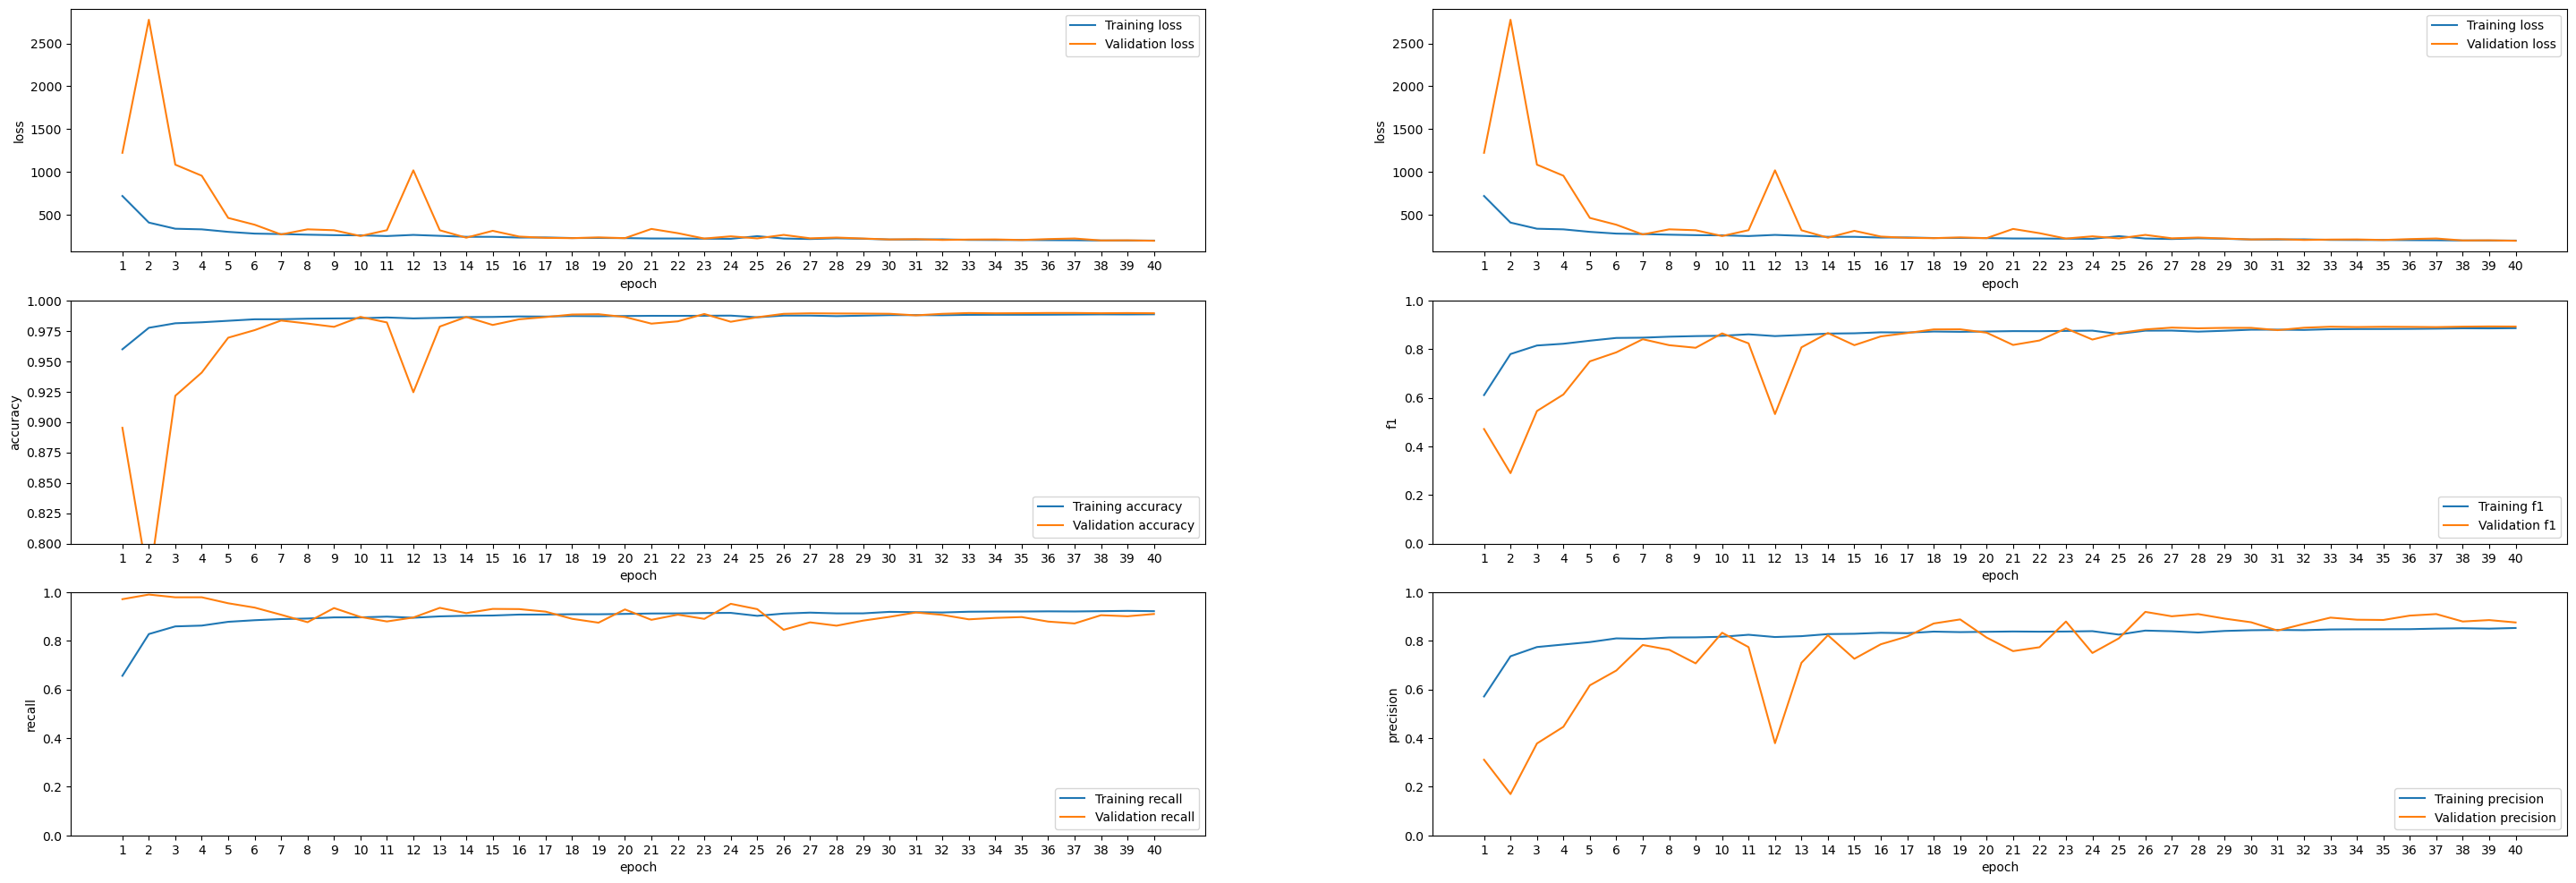

In [6]:
if Model.train_model:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy", "f1", "recall", "precision"]

    path = os.path.join(Model.Data.paths["FIGURES"], "training.svg")

    plots.plot_training_history(history=history.history, list_of_loss_names=plot_losses,
                                list_of_metric_names=plot_metrics,
                                save=Model.cfg["SAVE"], path=path)

1/1 [==============================] - 0s 498ms/step


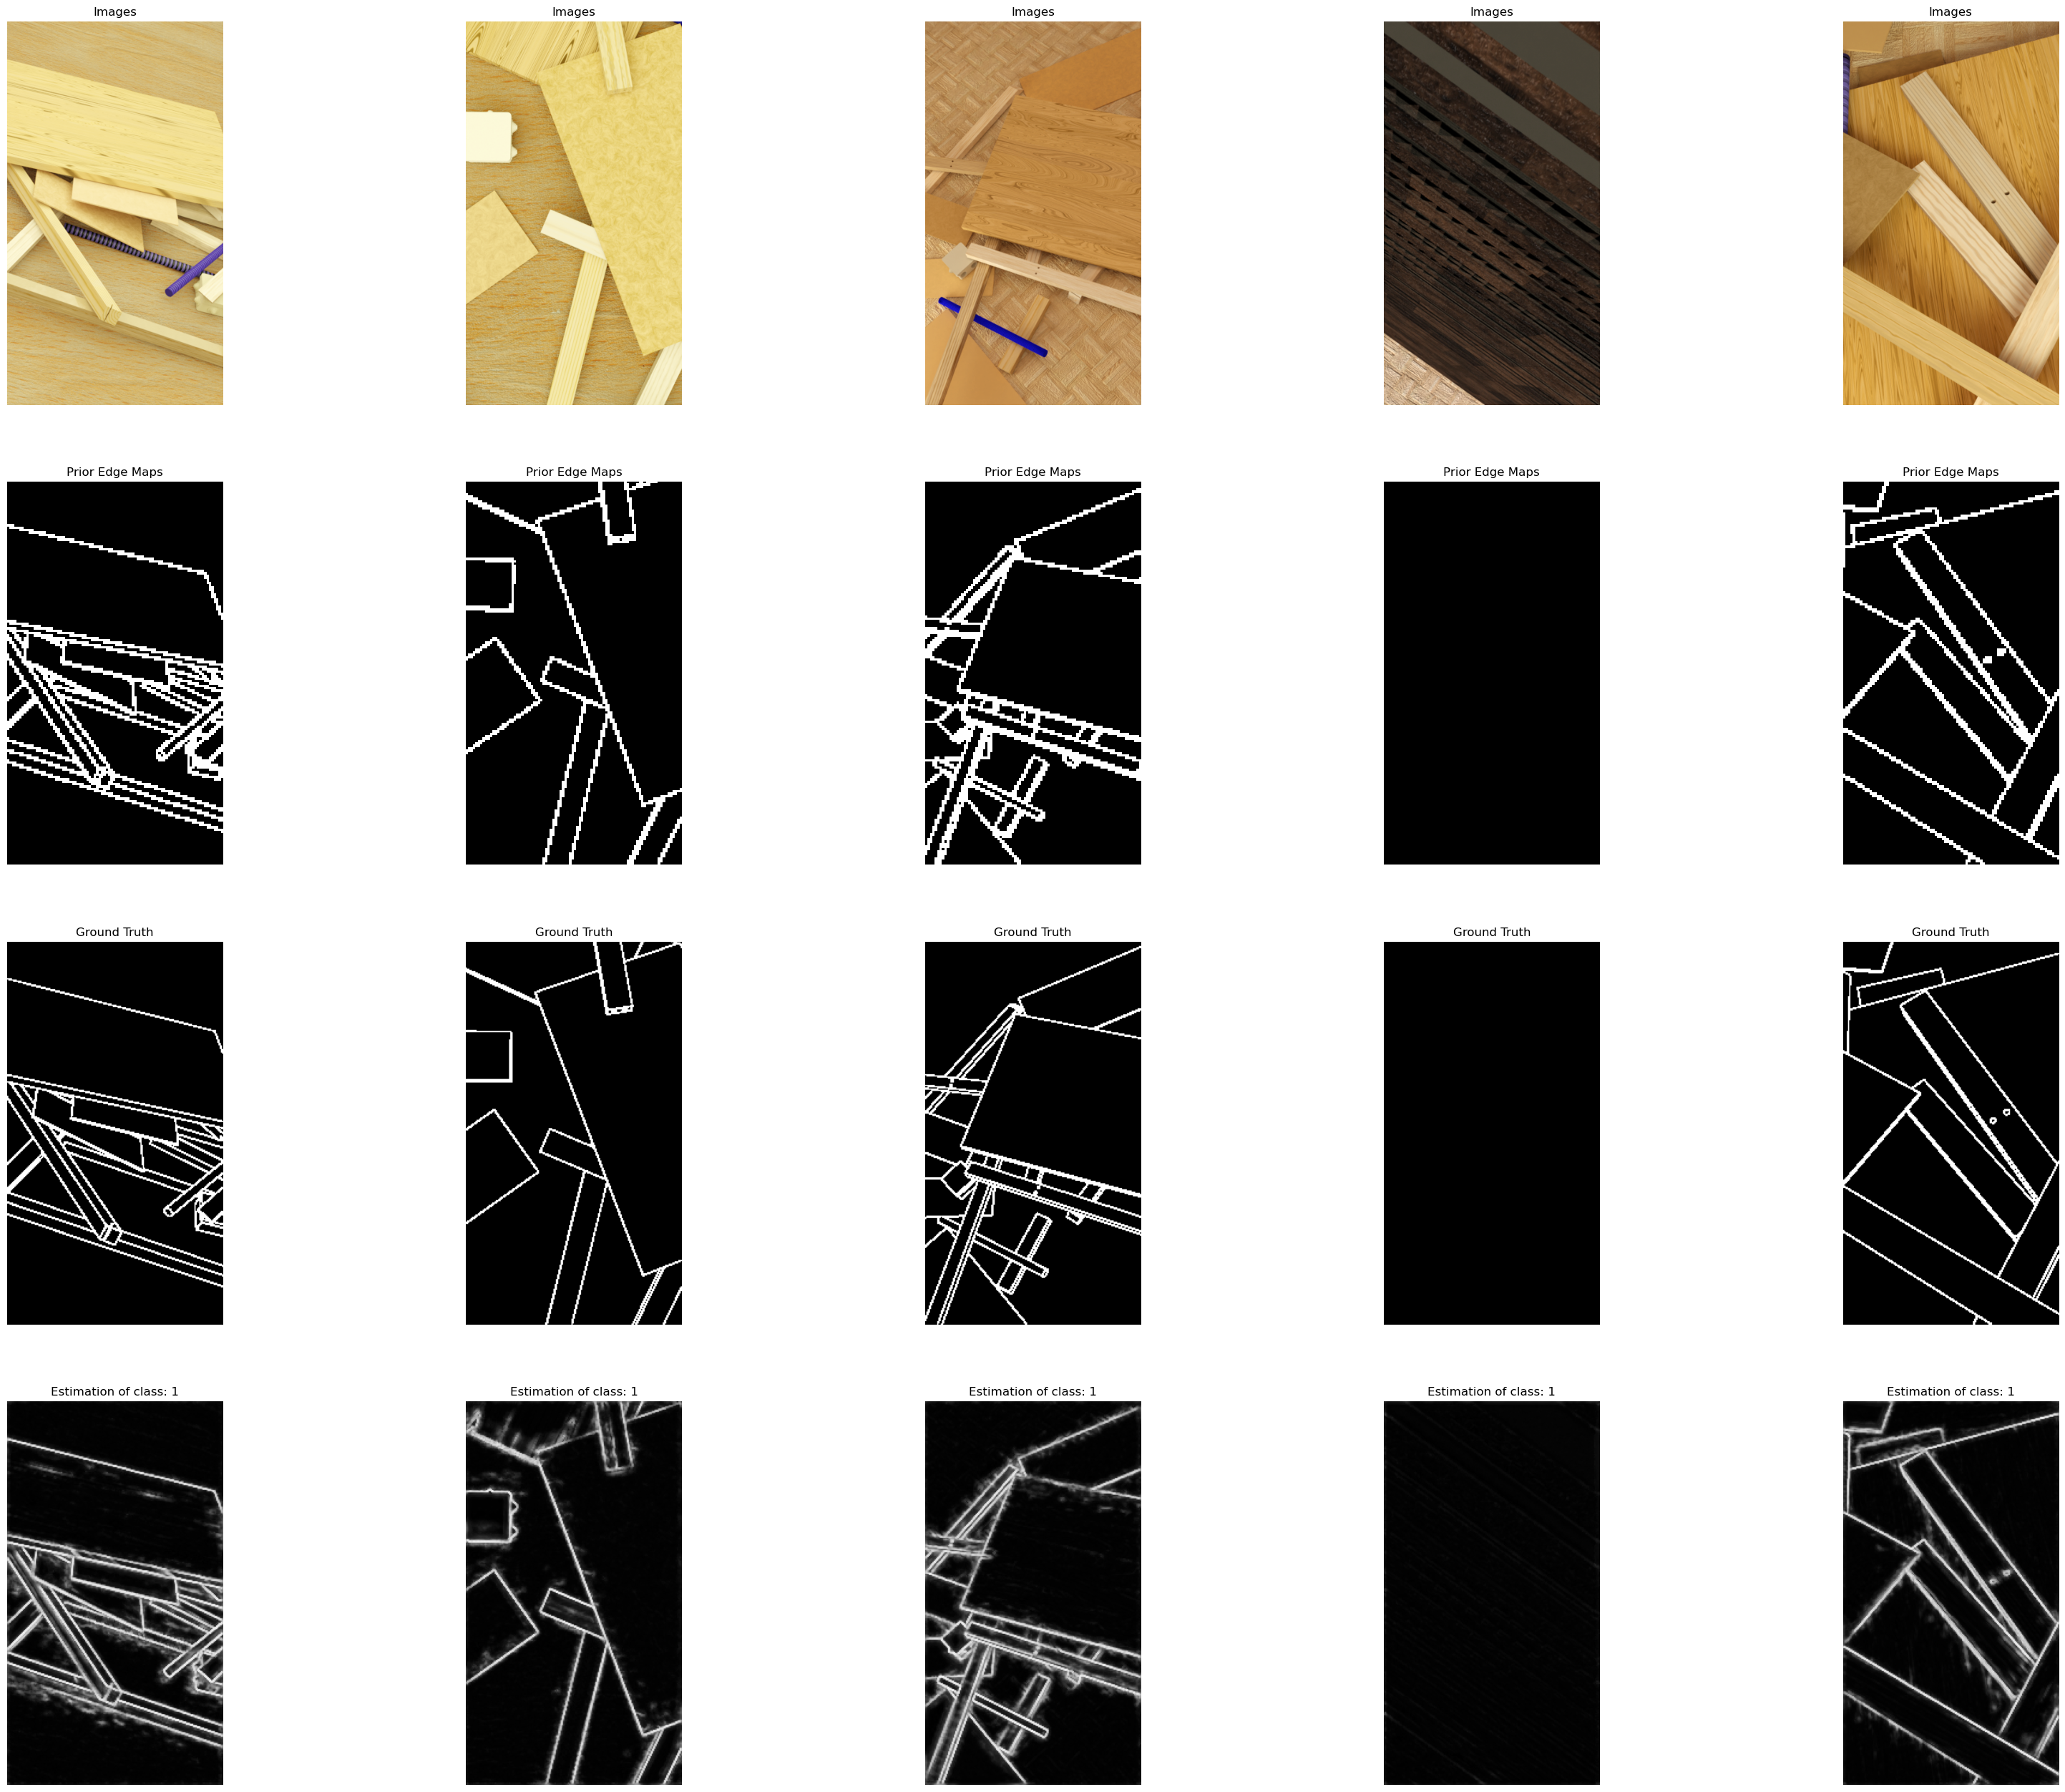

2022-12-08 17:54:32.368310: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'],
                                    prior = inp['in_edge'],
                                    labels=out['out_edge'],
                                    predictions=pred[0],
                                    batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

1/1 [==============================] - 0s 22ms/step


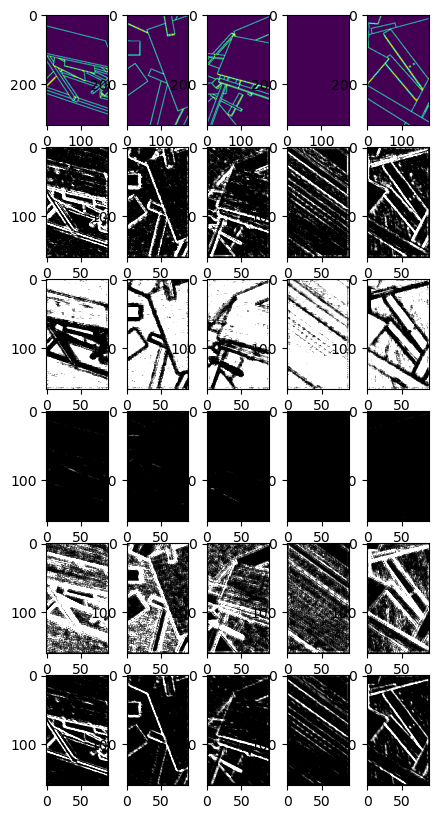

In [14]:
plt.figure(figsize=(5,10))

output = 4
num = 5
batch = 5
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
plt.show()

Max Accuracy Score = 0.988 at 0.600
MF1 = 0.879
MF1_1 = 0.879, ODS_1 = 0.500


[0.5]

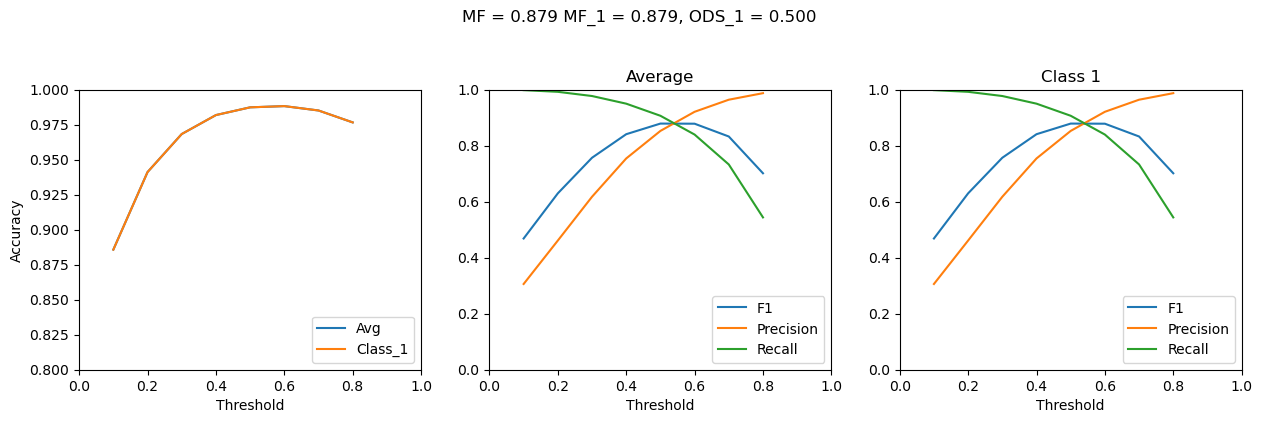

In [9]:
### Maximum F1 Score:
path_metrics_evaluation_plot = os.path.join(Model.Data.paths["FIGURES"],
                                            "threshold_metrics_evaluation_test_ds.svg")

edge_detection_plots.plot_threshold_metrics_evaluation(model=model, ds=test_ds,
                                                       num_classes=DataProcessing.num_classes['edge'],
                                                       classes_displayed_individually=True,
                                                       save=Model.cfg["SAVE"],
                                                       path=path_metrics_evaluation_plot,
                                                       accuracy_y_lim_min=0.8)


In [10]:
if Model.cfg["CONVERT_TO_TFLITE"]:
    Model.convert_model_to_tflite(model)

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the DEQUANTIZE op takes
tensor #13 as input and produces tensor #112 as output.

Subgraph#0 main(T#0, T#1) -> [T#282, T#232, T#255, T#288, T#272, T#275, T#236]
  Op#0 DEQUANTIZE(T#13[]) -> [T#112]
  Op#1 DEQUANTIZE(T#14[]) -> [T#113]
  Op#2 DEQUANTIZE(T#15[]) -> [T#114]
  Op#3 DEQUANTIZE(T#16[]) -> [T#115]
  Op#4 DEQUANTIZE(T#17[]) -> [T#116]
  Op#5 DEQUANTIZE(T#18[]) -> [T#117]
  Op#6 DEQUANTIZE(T#19[]) -> [T#118]
  Op#7 DEQUANTIZE(T#20[]) -> [T#119]
  Op#8 DEQUANTIZE(T#21[]) -> [T#120]
  Op#9 DEQUANTIZE(T#22[]) -> [T#121]
  Op#10 DEQUANTIZE(T#23[]) -> [T#122]
  Op#11 DEQUANTIZE(T#24[]) -> [T#123]
  Op#12 DEQUANTIZE(T#25[]) -> [T#124]
  Op#13 DEQUANTIZE(T#26[]) -> [T#125]
  Op#14 DEQUANTIZE(T#27[]) -> [T#126]
  Op#15 DEQUANTIZE(T#28[]) -> [T#127]
  Op#16 DEQUANTIZE(T#29[]) -> [T#128]
  Op#17 DEQUANTIZE(T#30[]) -> [T#129]


2022-12-08 17:54:44.917921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 17:54:44.917949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 17:54:44.918466: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/TFLITE
2022-12-08 17:54:44.938230: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 17:54:44.938261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/TFLITE
2022-12-08 17:54:44.985588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-08 17:54:45.005482: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-08 17:54:45